# Generating IC's

In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import os
import power as power

We start by generating some white noise $n(\mathbf{x})$

In [52]:
size = 30 # Mpc/h
n_grid = 64
n_grid_half = n_grid // 2
key, noise_key = jax.random.split(jax.random.PRNGKey(1))
rho = jax.random.normal(noise_key, (n_grid, n_grid, n_grid))

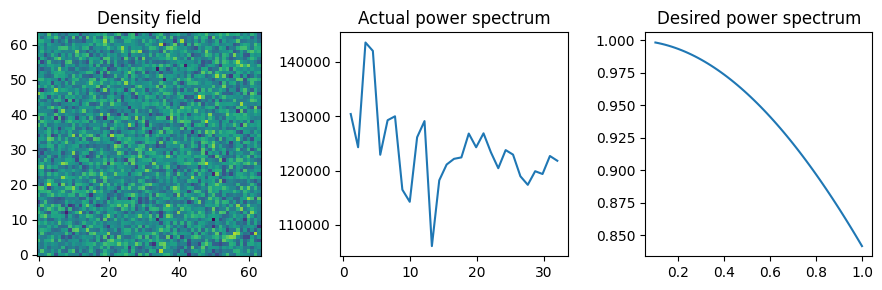

In [53]:
delta = power.overdensity(rho)

power_spectrum = power.PowerSpectrum(N = n_grid, n_bins=30)

k, Pk = power_spectrum(delta)

# lets define a desired power spectrum
k_desired = jnp.linspace(0.1, 1.0, n_grid)
Pk_desired = jnp.sin(k_desired) / k_desired


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
ax1.imshow(delta[n_grid//2], origin='lower')
ax1.set_title('Density field')
ax2.plot(k, Pk)
ax2.set_title('Actual power spectrum')
ax3.plot(k_desired, Pk_desired)
ax3.set_title('Desired power spectrum')

plt.tight_layout()


According to Pen et al. (1997), we need to compute the correlation Kernel

$$ 
A(k) = \sqrt{P(k)}.
$$

Then we can convolve the white noise with the correlation Kernel to generate the IC's 

$$
\delta(\mathbf{x}) = n(\mathbf{x}) \otimes A(\mathbf{x}).
$$

source : [INITIAL CONDITIONS FOR LARGE COSMOLOGICAL SIMULATIONS](https://arxiv.org/pdf/0804.3536)


In [54]:
# lets compute the correlation Kernel
Ax_lin = jnp.sqrt(Pk_desired)

coords = jnp.linspace(0, n_grid, n_grid, endpoint=False)
x, y, z = jnp.meshgrid(coords, coords, coords, indexing='ij')
index_grid = jnp.sqrt(x**2 + y**2 + z**2)
index_grid = jnp.abs(index_grid)
index_grid = index_grid.astype(jnp.int32)

Ax = Ax_lin.at[index_grid].get()

print(Ax)

# transform to fourier space
delta_k = jnp.fft.fftn(delta)
# apply correlation matrix
delta_k = jnp.matmul(delta_k, Ax)
# transform back to real space
delta = jnp.fft.ifftn(delta_k).real

[[[0.9991668  0.9989117  0.99862266 ... 0.9219423  0.9196461  0.9173173 ]
  [0.9989117  0.9989117  0.99862266 ... 0.9219423  0.9196461  0.9173173 ]
  [0.99862266 0.99862266 0.99862266 ... 0.9219423  0.9196461  0.9173173 ]
  ...
  [0.9219423  0.9219423  0.9219423  ... 0.9173173  0.9173173  0.9173173 ]
  [0.9196461  0.9196461  0.9196461  ... 0.9173173  0.9173173  0.9173173 ]
  [0.9173173  0.9173173  0.9173173  ... 0.9173173  0.9173173  0.9173173 ]]

 [[0.9989117  0.9989117  0.99862266 ... 0.9219423  0.9196461  0.9173173 ]
  [0.9989117  0.9989117  0.99862266 ... 0.9219423  0.9196461  0.9173173 ]
  [0.99862266 0.99862266 0.9982996  ... 0.9219423  0.9196461  0.9173173 ]
  ...
  [0.9219423  0.9219423  0.9219423  ... 0.9173173  0.9173173  0.9173173 ]
  [0.9196461  0.9196461  0.9196461  ... 0.9173173  0.9173173  0.9173173 ]
  [0.9173173  0.9173173  0.9173173  ... 0.9173173  0.9173173  0.9173173 ]]

 [[0.99862266 0.99862266 0.99862266 ... 0.9219423  0.9196461  0.9173173 ]
  [0.99862266 0.998622

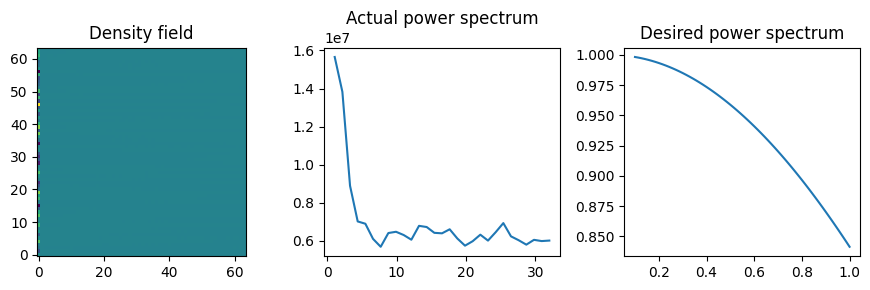

In [55]:
k, Pk = power_spectrum(delta)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
ax1.imshow(delta[n_grid_half], origin='lower')
ax1.set_title('Density field')
ax2.plot(k, Pk)
ax2.set_title('Actual power spectrum')
ax3.plot(k_desired, Pk_desired)
ax3.set_title('Desired power spectrum')

plt.tight_layout()